# Genpact Machine Learning Hackathon

<img src='../images/problem_statement.png'>
<img src='../images/data_dict.png'>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import gc
import catboost as cb
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold

In [3]:
#pd.set_option('display.max_rows', None)
def show_all(df, nrow, ncol):
    with pd.option_context('display.max_rows', nrow, 'display.max_columns', ncol):
        display(df)

In [4]:
FILES_PATH = '../input/'
SUB_PATH = '../submissions/'

In [5]:
fci_df = pd.read_csv(f"{FILES_PATH}/fulfilment_center_info.csv")
mi_df = pd.read_csv(f"{FILES_PATH}/meal_info.csv")
train_df = pd.read_csv(f"{FILES_PATH}/train.csv")
test_df = pd.read_csv(f"{FILES_PATH}/test.csv")
sub_df = pd.read_csv(f"{FILES_PATH}/sample_submission.csv")

In [4]:
# head of fulfilment_center_info file
fci_df.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [5]:
print("Shape of fulfilment_center_info :", fci_df.shape)

Shape of fulfilment_center_info : (77, 5)


In [6]:
# NaN values in fulfilment_center_info
fci_df.isnull().sum()

center_id      0
city_code      0
region_code    0
center_type    0
op_area        0
dtype: int64

In [7]:
# head of meal_info file
mi_df.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [8]:
print("Shape of meal_info: ", mi_df.shape)

Shape of meal_info:  (51, 3)


In [9]:
# NaN values in meal_info
mi_df.isnull().sum()

meal_id     0
category    0
cuisine     0
dtype: int64

In [10]:
# Head of Train file (historical demand data)
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [11]:
print("Shape of train: ", train_df.shape)

Shape of train:  (456548, 9)


In [12]:
# NaN values in train data
train_df.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [13]:
# Head of Test data
test_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [14]:
print("Shape of Test: ", test_df.shape)

Shape of Test:  (32573, 8)


In [15]:
# NaN values in test data
test_df.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
dtype: int64

## EDA

### `fulfilment_center_info`

In [16]:
print("Total number of centers : ", fci_df['center_id'].nunique())

Total number of centers :  77


In [17]:
print("Types of centers : \n")
print(fci_df['center_type'].unique())

Types of centers : 

['TYPE_A' 'TYPE_B' 'TYPE_C']


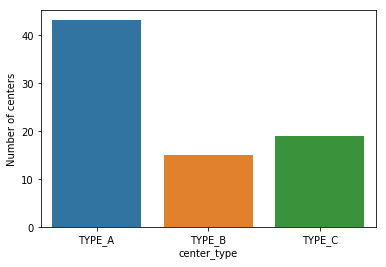

In [18]:
ax = sns.countplot(fci_df['center_type'])
ax.set(ylabel='Number of centers')
plt.show()

In [19]:
print("Total Number of cities: ", fci_df['city_code'].nunique())

Total Number of cities:  51


We have 77 stores in 51 cities, so some city have more than 1 center.

In [20]:
print("Total number of regions: ", fci_df['region_code'].nunique())

Total number of regions:  8


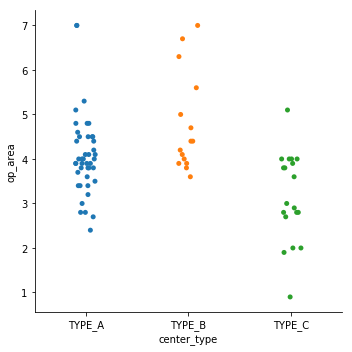

In [21]:
sns.catplot(x = 'center_type', y = 'op_area', data=fci_df)
plt.show()

In [22]:
fci_df['region_code'] = fci_df['city_code'].astype(str) + "_" + fci_df['region_code'].astype(str)
fci_df['region_code'].nunique()

51

so in the one city there is not any centers which are in different regions.
so maybe region code will not be helpful.

In [6]:
fci_df.drop('region_code', axis=1, inplace=True)

### `meal_info`

In [24]:
print("Total number of different types of meal: ", mi_df['meal_id'].nunique())

Total number of different types of meal:  51


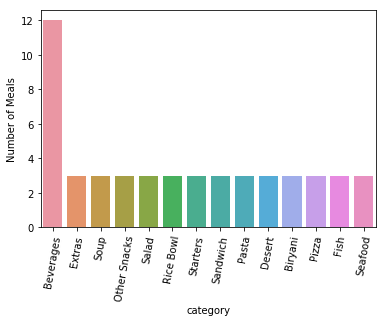

In [25]:
ax = sns.countplot(mi_df['category'])
ax.set(ylabel= "Number of Meals")
plt.xticks(rotation=80)
plt.show()

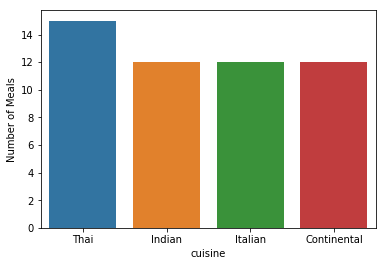

In [26]:
ax = sns.countplot(mi_df['cuisine'])
ax.set(ylabel= "Number of Meals")
plt.show()

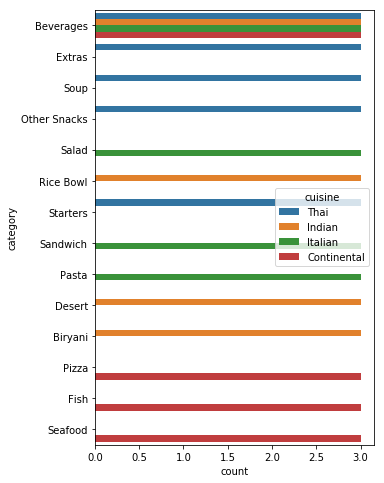

In [27]:
fig, ax = plt.subplots(figsize=(5,8))
sns.countplot(y = mi_df['category'], hue=mi_df['cuisine'], ax=ax)
plt.show()

### `Train (historical meal order data)`

In [7]:
train_df = pd.merge(train_df, fci_df, on='center_id')
test_df = pd.merge(test_df, fci_df, on='center_id')

train_df = pd.merge(train_df, mi_df, on='meal_id')
test_df = pd.merge(test_df, mi_df, on='meal_id')

In [8]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,TYPE_C,2.0,Beverages,Thai
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,TYPE_C,2.0,Beverages,Thai
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,TYPE_C,2.0,Beverages,Thai
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,TYPE_C,2.0,Beverages,Thai
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,TYPE_C,2.0,Beverages,Thai


In [52]:
c_m_tr = (train_df['center_id'].astype(str) + "_" + train_df['meal_id'].astype(str)).unique()
print("there are ", len(c_m_tr), " center-meal pairs in train data")

there are  3597  center-meal pairs in train data


In [53]:
c_m_te = (test_df['center_id'].astype(str) + "_" + test_df['meal_id'].astype(str)).unique()
print("there are ", len(c_m_te), " center-meal pairs in test data")

there are  3548  center-meal pairs in test data


In [55]:
# check if test set has any new center-mean pair or not
print("There are ", len(set(c_m_te) - set(c_m_tr)), " new center-meal pairs in test dataset which are not present in train dataset")
print(set(c_m_te) - set(c_m_tr))

There are  3  new center-meal pairs in test dataset which are not present in train dataset
{'73_2956', '73_1571', '92_2104'}


In [11]:
test_df[(test_df['center_id']==73) & (test_df['meal_id'].isin([2956, 1571]))].shape[0]

11

In [9]:
test_df[(test_df['center_id']==92) & (test_df['meal_id'].isin([2104]))].shape[0]

2

There should be 77*51 = 3927 center-meal pair, but we have 3597 pairs in train data, that means some centers did not sell some of the meals.

There should be 3597*145 = 521565 records in past 145 week data, but we have 456548 records. which means some centers did not sell some meal for some week or they stared selling some new type of meal after some weeks.
Same with test data.

Test set has only 3548 center-meal pair, that means some of the centers did not sell some type of meals in this 10 week.

Here in the test set (future 10 week), center 73 started selling meal 2956 & 1571, center 92 started selling meal 2104, which they have never sold in last 145 weeks. There are only 13 records with unknown center-meal pair in test set.

In [12]:
train_df['b_c_p_diff'] = train_df['base_price'] - train_df['checkout_price']

In [13]:
test_df['b_c_p_diff'] = test_df['base_price'] - test_df['checkout_price']

#### Catboost model1 : LB : 158

In [64]:
test_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,center_type,op_area,category,cuisine,b_c_p_diff
0,1028232,146,55,1885,158.11,159.11,0,0,647,TYPE_C,2.0,Beverages,Thai,1.0
1,1262649,147,55,1885,159.11,159.11,0,0,647,TYPE_C,2.0,Beverages,Thai,0.0
2,1453211,149,55,1885,157.14,158.14,0,0,647,TYPE_C,2.0,Beverages,Thai,1.0
3,1262599,150,55,1885,159.14,157.14,0,0,647,TYPE_C,2.0,Beverages,Thai,-2.0
4,1495848,151,55,1885,160.11,159.11,0,0,647,TYPE_C,2.0,Beverages,Thai,-1.0


In [69]:
features0 = [col for col in test_df.columns if col not in ['id']]

In [71]:
features0

['week',
 'center_id',
 'meal_id',
 'checkout_price',
 'base_price',
 'emailer_for_promotion',
 'homepage_featured',
 'city_code',
 'center_type',
 'op_area',
 'category',
 'cuisine',
 'b_c_p_diff']

In [67]:
cat_ind0 = [1, 2, 5, 6, 7, 8, 10, 11]

In [68]:
cat_re0 = cb.CatBoostRegressor(random_seed=2018)

In [72]:
cat_re0.fit(train_df[features0], train_df['num_orders'], cat_features=cat_ind0, verbose=False, plot=True)

MetricVisualizer(data={'catboost_info': {'path': 'catboost_info', 'name': 'catboost_info', 'content': {'passed…

In [81]:
100 * np.sqrt(mean_squared_log_error(np.clip(cat_re0.predict(train_df[features0]), 0, 10000), train_df['num_orders']))

55.10299392383495

In [83]:
sub_df['num_orders'] = np.clip(cat_re0.predict(test_df[features0]), 0, 10000)
sub_df.to_csv(f'{SUB_PATH}/cat0.csv', index=False)

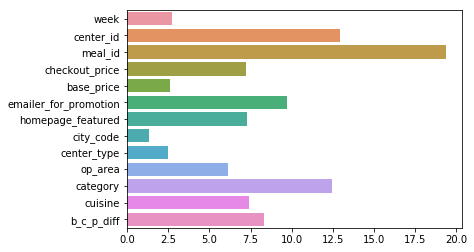

In [85]:
sns.barplot(cat_re0.feature_importances_, features0)
plt.show()

In [98]:
print("params : ", cat_re0.get_params())
print("Learning rate: ", cat_re0.learning_rate_)
print("tree counts: ", cat_re0.tree_count_)

params :  {'loss_function': 'RMSE', 'random_seed': 2018}
Learning rate:  0.02999999933
tree counts:  1000


### Further analysis on entire data and feature engineering

In [28]:
all_df = train_df.append(test_df, sort=True).reset_index(drop=True)
all_df = all_df[train_df.columns]

In [37]:
all_df = all_df.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)

In [56]:
all_df['last_pre_cp_diff'] = all_df['checkout_price'].shift(1) - all_df['checkout_price']

In [57]:
all_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,center_type,op_area,category,cuisine,b_c_p_diff,last_pre_cp_diff
0,1436842,1,10,1062,181.39,181.39,0,0,865.0,590,TYPE_B,6.3,Beverages,Italian,0.0,NaN
1,1205013,2,10,1062,183.36,182.36,0,0,782.0,590,TYPE_B,6.3,Beverages,Italian,-1.0,-1.97
2,1447751,3,10,1062,184.36,182.36,0,0,851.0,590,TYPE_B,6.3,Beverages,Italian,-2.0,-1.00
3,1014968,4,10,1062,182.36,183.36,0,0,1202.0,590,TYPE_B,6.3,Beverages,Italian,1.0,2.00
4,1003563,5,10,1062,183.39,181.39,0,0,958.0,590,TYPE_B,6.3,Beverages,Italian,-2.0,-1.03


In [74]:
for _, r in all_df.groupby(['center_id', 'meal_id'])['week'].first().reset_index().iterrows():
    all_df.loc[(all_df['center_id']==r['center_id']) & (all_df['meal_id']==r['meal_id']) & (all_df['week']==r['week']), 'last_pre_cp_diff'] = all_df[(all_df['center_id']==r['center_id']) & (all_df['meal_id']==r['meal_id']) & (all_df['week']!=r['week'])]['last_pre_cp_diff'].mean()

In [76]:
all_df['price_increase'] = all_df['last_pre_cp_diff'] < 0

In [94]:
all_df['high_price_che_than_base'] = all_df['b_c_p_diff'] < 0

In [95]:
all_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,center_type,op_area,category,cuisine,b_c_p_diff,last_pre_cp_diff,price_increase,high_price_che_than_base
0,1436842,1,10,1062,181.39,181.39,0,0,865.0,590,TYPE_B,6.3,Beverages,Italian,0.0,0.125974,False,False
1,1205013,2,10,1062,183.36,182.36,0,0,782.0,590,TYPE_B,6.3,Beverages,Italian,-1.0,-1.970000,True,True
2,1447751,3,10,1062,184.36,182.36,0,0,851.0,590,TYPE_B,6.3,Beverages,Italian,-2.0,-1.000000,True,True
3,1014968,4,10,1062,182.36,183.36,0,0,1202.0,590,TYPE_B,6.3,Beverages,Italian,1.0,2.000000,False,False
4,1003563,5,10,1062,183.39,181.39,0,0,958.0,590,TYPE_B,6.3,Beverages,Italian,-2.0,-1.030000,True,True


In [107]:
all_df[all_df['last_pre_cp_diff'].isnull()]

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,center_type,op_area,category,cuisine,b_c_p_diff,last_pre_cp_diff,price_increase,high_price_che_than_base
326977,1067161,85,101,1571,581.03,583.03,0,0,14.0,699,TYPE_C,2.8,Fish,Continental,2.0,NaN,False,False
423333,1488069,134,145,1571,602.43,601.43,0,0,42.0,620,TYPE_A,3.9,Fish,Continental,-1.0,NaN,False,True
424809,1408899,131,145,2104,437.53,435.53,0,0,68.0,620,TYPE_A,3.9,Fish,Continental,-2.0,NaN,False,True


In [111]:
show_all(all_df[423330:423336])

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,center_type,op_area,category,cuisine,b_c_p_diff,last_pre_cp_diff,price_increase,high_price_che_than_base
423330,1309908,153,145,1558,564.60,564.60,0,0,NaN,620,TYPE_A,3.9,Pizza,Continental,0.0,-1.000000,True,False
423331,1016495,154,145,1558,563.60,563.60,0,0,NaN,620,TYPE_A,3.9,Pizza,Continental,0.0,1.000000,False,False
423332,1441001,155,145,1558,562.60,563.60,0,0,NaN,620,TYPE_A,3.9,Pizza,Continental,1.0,1.000000,False,False
423333,1488069,134,145,1571,602.43,601.43,0,0,42.0,620,TYPE_A,3.9,Fish,Continental,-1.0,NaN,False,True
423334,1044570,1,145,1727,426.83,426.83,0,0,312.0,620,TYPE_A,3.9,Rice Bowl,Indian,0.0,-0.125974,True,False
423335,1152336,2,145,1727,427.83,425.83,0,0,176.0,620,TYPE_A,3.9,Rice Bowl,Indian,-2.0,-1.000000,True,True


Here we have some center-meal pair which has only occurred once, that's why we have NaN value for last_pre_cp_diff column for these 3 records. Let's put 0 for this.

In [112]:
all_df['last_pre_cp_diff'] = all_df['last_pre_cp_diff'].fillna(0)

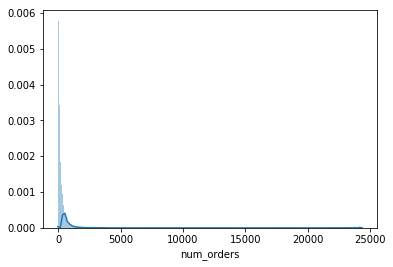

In [87]:
sns.distplot(all_df['num_orders'].dropna(), bins=500)
plt.show()

Target variable is highly skewd, so it's better if we use log of it for prediction.

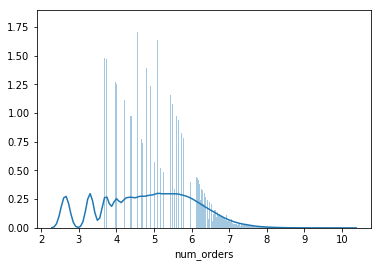

In [89]:
sns.distplot(np.log(all_df['num_orders'].dropna()), bins=500)
plt.show()

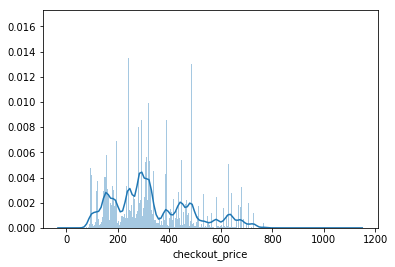

In [91]:
sns.distplot(all_df['checkout_price'], bins=500)
plt.show()

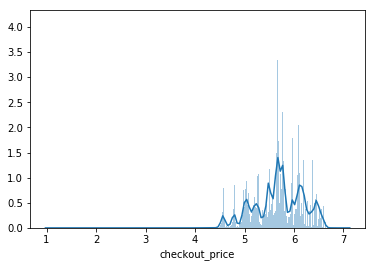

In [117]:
sns.distplot(np.log(all_df['checkout_price']), bins=500)
plt.show()

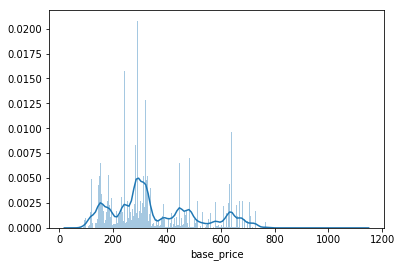

In [102]:
sns.distplot(all_df['base_price'], bins=500)
plt.show()

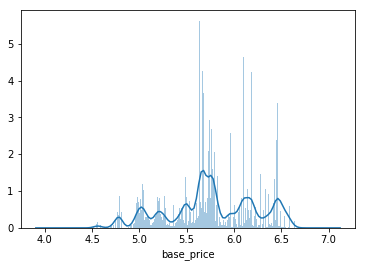

In [118]:
sns.distplot(np.log(all_df['base_price']), bins=500)
plt.show()

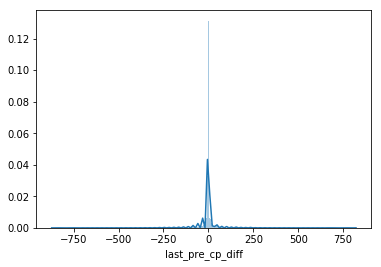

In [113]:
sns.distplot(all_df['last_pre_cp_diff'], bins=500)
plt.show()

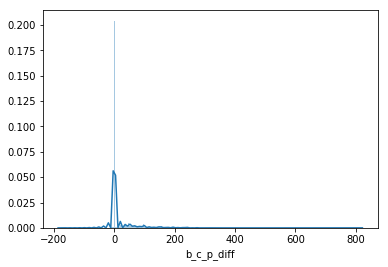

In [116]:
sns.distplot(all_df['b_c_p_diff'], bins=500)
plt.show()

### Catboost using below data LB: 160

In [121]:
all_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,center_type,op_area,category,cuisine,b_c_p_diff,last_pre_cp_diff,price_increase,high_price_che_than_base
0,1436842,1,10,1062,181.39,181.39,0,0,865.0,590,TYPE_B,6.3,Beverages,Italian,0.0,0.125974,False,False
1,1205013,2,10,1062,183.36,182.36,0,0,782.0,590,TYPE_B,6.3,Beverages,Italian,-1.0,-1.970000,True,True
2,1447751,3,10,1062,184.36,182.36,0,0,851.0,590,TYPE_B,6.3,Beverages,Italian,-2.0,-1.000000,True,True
3,1014968,4,10,1062,182.36,183.36,0,0,1202.0,590,TYPE_B,6.3,Beverages,Italian,1.0,2.000000,False,False
4,1003563,5,10,1062,183.39,181.39,0,0,958.0,590,TYPE_B,6.3,Beverages,Italian,-2.0,-1.030000,True,True


In [122]:
trn_df = all_df[all_df['id'].isin(train_df['id'].values)].reset_index(drop=True)

In [126]:
tst_df = all_df[all_df['id'].isin(test_df['id'].values)].reset_index(drop=True)

In [152]:
trn_df = trn_df.reset_index(drop=True)
tst_df = tst_df.reset_index(drop=True)

In [133]:
features2 = [col for col in tst_df.columns if col not in ['id', 'checkout_price', 'base_price', 'city_code', 'center_type', 'num_orders']]

In [134]:
features2

['week',
 'center_id',
 'meal_id',
 'emailer_for_promotion',
 'homepage_featured',
 'op_area',
 'category',
 'cuisine',
 'b_c_p_diff',
 'last_pre_cp_diff',
 'price_increase',
 'high_price_che_than_base']

In [137]:
cat_ind2 = [1, 2, 3, 4, 6, 7, 10, 11]

In [136]:
cat_rg2 = cb.CatBoostRegressor(iterations=2000, learning_rate=0.03, depth=8, loss_function='RMSE', random_seed=2018, l2_leaf_reg=5)

In [141]:
cv_data2 = cb.cv(cb.Pool(trn_df[features2], trn_df['num_orders'], cat_features=cat_ind2), cat_rg2.get_params(), nfold=5, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [144]:
best_score = np.min(cv_data2['test-RMSE-mean'])

In [145]:
best_score

154.82754552613645

Best RMSE 154.82 at 2000 iterations.

iterations=2000, learning_rate=0.03, depth=8, loss_function='RMSE', random_seed=2018, l2_leaf_reg=5

In [147]:
cat_rg2 = cb.CatBoostRegressor(iterations=2000, learning_rate=0.08, depth=8, loss_function='RMSE', random_seed=2018, l2_leaf_reg=5)

In [161]:
trn_df_random = trn_df.loc[np.random.permutation(trn_df.shape[0])]

In [162]:
cat_rg2.fit(trn_df_random[features2], trn_df_random['num_orders'], cat_features=cat_ind2, verbose=False, plot=True)

MetricVisualizer(data={'catboost_info': {'path': 'catboost_info', 'name': 'catboost_info', 'content': {'passed…

In [163]:
100 * np.sqrt(mean_squared_log_error(np.clip(cat_rg2.predict(trn_df_random[features2]), 0, 10000), trn_df_random['num_orders']))

51.41629037199213

In [165]:
print("params : ", cat_rg2.get_params())
print("Learning rate: ", cat_rg2.learning_rate_)
print("tree counts: ", cat_rg2.tree_count_)

params :  {'loss_function': 'RMSE', 'learning_rate': 0.08, 'depth': 8, 'random_seed': 2018, 'l2_leaf_reg': 5, 'iterations': 2000}
Learning rate:  0.07999999821
tree counts:  2000


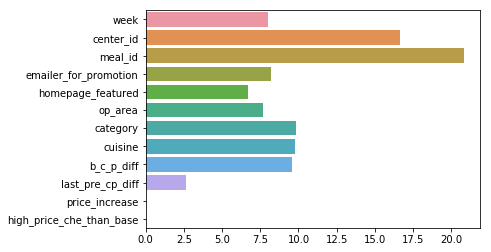

In [166]:
sns.barplot(cat_rg2.feature_importances_, features2)
plt.show()

In [167]:
sub_df['num_orders'] = np.clip(cat_rg2.predict(tst_df[features2]), 0, 10000)
sub_df.to_csv(f'{SUB_PATH}/cat2.csv', index=False)

## New  Beginning

In [5]:
fci_df = pd.read_csv(f"{FILES_PATH}/fulfilment_center_info.csv")
mi_df = pd.read_csv(f"{FILES_PATH}/meal_info.csv")
train_df = pd.read_csv(f"{FILES_PATH}/train.csv")
test_df = pd.read_csv(f"{FILES_PATH}/test.csv")
sub_df = pd.read_csv(f"{FILES_PATH}/sample_submission.csv")

In [6]:
train_df = pd.merge(train_df, fci_df, on='center_id')
test_df = pd.merge(test_df, fci_df, on='center_id')

train_df = pd.merge(train_df, mi_df, on='meal_id')
test_df = pd.merge(test_df, mi_df, on='meal_id')

In [7]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,TYPE_C,2.0,Beverages,Thai
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,TYPE_C,2.0,Beverages,Thai
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,TYPE_C,2.0,Beverages,Thai


In [8]:
train_df['train_or_test'] = 'train'
test_df['train_or_test'] = 'test'

In [9]:
train_df['num_orders'] = np.log1p(train_df['num_orders'])

In [10]:
all_df = train_df.append(test_df, sort=True).reset_index(drop=True)[train_df.columns]

In [11]:
all_df = all_df.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)

In [12]:
all_df['checkout_price'] = np.log1p(all_df['checkout_price'])
all_df['base_price'] = np.log1p(all_df['base_price'])

In [13]:
all_df['discount_on_base'] = (all_df['base_price'] - all_df['checkout_price']) / all_df['base_price']

In [14]:
all_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,train_or_test,discount_on_base
0,1436842,1,10,1062,5.206147,5.206147,0,0,6.763885,590,56,TYPE_B,6.3,Beverages,Italian,train,0.000000
1,1205013,2,10,1062,5.216890,5.211451,0,0,6.663133,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.001044
2,1447751,3,10,1062,5.222300,5.211451,0,0,6.747587,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.002082
3,1014968,4,10,1062,5.211451,5.216890,0,0,7.092574,590,56,TYPE_B,6.3,Beverages,Italian,train,0.001043
4,1003563,5,10,1062,5.217053,5.206147,0,0,6.865891,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.002095


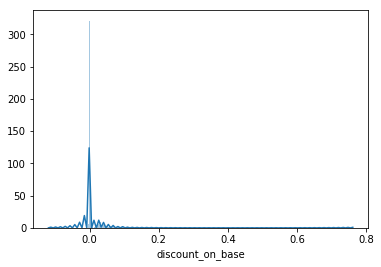

In [15]:
sns.distplot(all_df['discount_on_base'], bins=500)
plt.show()

In [16]:
all_df['neg_discount'] = (all_df['discount_on_base'] < 0).astype(int)

In [17]:
all_df['price_last_curr_diff'] = (all_df['checkout_price'].shift(1) - all_df['checkout_price']).fillna(1)/ all_df['checkout_price'].shift(1).fillna(1)

In [18]:
for _, r in all_df.groupby(['center_id', 'meal_id'])['week'].first().reset_index().iterrows():
    all_df.loc[(all_df['center_id']==r['center_id']) & (all_df['meal_id']==r['meal_id']) & (all_df['week']==r['week']), 'price_last_curr_diff'] = all_df[(all_df['center_id']==r['center_id']) & (all_df['meal_id']==r['meal_id']) & (all_df['week']!=r['week'])]['price_last_curr_diff'].mean()

In [19]:
all_df['price_last_curr_diff'] = all_df['price_last_curr_diff'].fillna(0)

In [20]:
all_df['price_increase'] = (all_df['price_last_curr_diff'] < 0).astype(int)

Time based cross validation:

Here we take last 10 weeks from train set as a validation data.

In [21]:
all_df.loc[all_df['week'].isin(np.arange(136,146)), 'train_or_test'] = 'val'

In [22]:
all_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,train_or_test,discount_on_base,neg_discount,price_last_curr_diff,price_increase
0,1436842,1,10,1062,5.206147,5.206147,0,0,6.763885,590,56,TYPE_B,6.3,Beverages,Italian,train,0.000000,0,0.000086,0
1,1205013,2,10,1062,5.216890,5.211451,0,0,6.663133,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.001044,1,-0.002064,1
2,1447751,3,10,1062,5.222300,5.211451,0,0,6.747587,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.002082,1,-0.001037,1
3,1014968,4,10,1062,5.211451,5.216890,0,0,7.092574,590,56,TYPE_B,6.3,Beverages,Italian,train,0.001043,0,0.002077,0
4,1003563,5,10,1062,5.217053,5.206147,0,0,6.865891,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.002095,1,-0.001075,1


In [23]:
trn_df = all_df.loc[all_df.train_or_test.isin(['train','val']), :]

In [24]:
Y_val = trn_df.loc[trn_df.train_or_test=='val', 'num_orders'].values.reshape((-1))
Y_train = trn_df.loc[trn_df.train_or_test=='train', 'num_orders'].values.reshape((-1))
trn_df.loc[trn_df.train_or_test=='val', 'num_orders'] = np.nan

/home/nishant/venvs_dir/DS/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### Some functions to create aggregated, rolling mean/median, and exponentially weighted features.

Code from : https://www.kaggle.com/abhilashawasthi/feature-engineering-lgb-model

In [25]:
# Monthwise aggregated sales values
def create_sales_agg_monthwise_features(df, gpby_cols, target_col, agg_funcs):
    '''
    Creates various sales agg features with given agg functions  
    '''
    gpby = df.groupby(gpby_cols)
    newdf = df[gpby_cols].drop_duplicates().reset_index(drop=True)
    for agg_name, agg_func in agg_funcs.items():
        aggdf = gpby[target_col].agg(agg_func).reset_index()
        aggdf.rename(columns={target_col:target_col+'_'+agg_name}, inplace=True)
        newdf = newdf.merge(aggdf, on=gpby_cols, how='left')
    return newdf

In [26]:
# Features constructed from previous sales values

#Creating sales lag features
def create_sales_lag_feats(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
        df['_'.join([target_col, 'lag', str(i)])] = \
                gpby[target_col].shift(i).values + np.random.normal(scale=1.6, size=(len(df),))
    return df


# Creating sales rolling mean features
def create_sales_rmean_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                             shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmean', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).mean().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df


# Creating sales rolling median features
def create_sales_rmed_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                            shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmed', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).median().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df

# Creating sales exponentially weighted mean features
def create_sales_ewm_feats(df, gpby_cols, target_col, alpha=[0.9], shift=[1]):
    gpby = df.groupby(gpby_cols)
    for a in alpha:
        for s in shift:
            df['_'.join([target_col, 'lag', str(s), 'ewm', str(a)])] = \
                gpby[target_col].shift(s).ewm(alpha=a).mean().values
    return df

In [27]:
def one_hot_encoder(df, ohe_cols):
    '''
    One-Hot Encoder function
    '''
    print('Creating OHE features..\nOld df shape:{}'.format(df.shape))
    df = pd.get_dummies(df, columns=ohe_cols)
    print('New df shape:{}'.format(df.shape))
    return df

In [28]:
# # Creating num_orders lag, rolling mean, rolling median, ohe features of the above train set
trn_df = create_sales_lag_feats(trn_df, gpby_cols=['center_id','meal_id'], target_col='num_orders', 
                               lags=[10,11,12,13,14,15,26,27,28,29])

trn_df = create_sales_rmean_feats(trn_df, gpby_cols=['center_id','meal_id'], 
                                 target_col='num_orders', windows=[26,52,104], 
                                 min_periods=3, win_type='triang')

trn_df = create_sales_rmed_feats(trn_df, gpby_cols=['center_id','meal_id'], 
                                 target_col='num_orders', windows=[26,52,104], 
                                 min_periods=3, win_type=None)

trn_df = create_sales_ewm_feats(trn_df, gpby_cols=['center_id','meal_id'], 
                               target_col='num_orders', 
                               alpha=[0.95, 0.9, 0.8, 0.7, 0.6, 0.5], 
                               shift=[10,11,12,13,14,15,26,27,28,29])


/home/nishant/venvs_dir/DS/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/nishant/venvs_dir/DS/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/nishant/venvs_dir/DS/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

In [29]:
trn_df.shape

(456548, 96)

In [30]:
show_all(trn_df, 5, None)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,train_or_test,discount_on_base,neg_discount,price_last_curr_diff,price_increase,num_orders_lag_10,num_orders_lag_11,num_orders_lag_12,num_orders_lag_13,num_orders_lag_14,num_orders_lag_15,num_orders_lag_26,num_orders_lag_27,num_orders_lag_28,num_orders_lag_29,num_orders_rmean_26,num_orders_rmean_52,num_orders_rmean_104,num_orders_rmed_26,num_orders_rmed_52,num_orders_rmed_104,num_orders_lag_10_ewm_0.95,num_orders_lag_11_ewm_0.95,num_orders_lag_12_ewm_0.95,num_orders_lag_13_ewm_0.95,num_orders_lag_14_ewm_0.95,num_orders_lag_15_ewm_0.95,num_orders_lag_26_ewm_0.95,num_orders_lag_27_ewm_0.95,num_orders_lag_28_ewm_0.95,num_orders_lag_29_ewm_0.95,num_orders_lag_10_ewm_0.9,num_orders_lag_11_ewm_0.9,num_orders_lag_12_ewm_0.9,num_orders_lag_13_ewm_0.9,num_orders_lag_14_ewm_0.9,num_orders_lag_15_ewm_0.9,num_orders_lag_26_ewm_0.9,num_orders_lag_27_ewm_0.9,num_orders_lag_28_ewm_0.9,num_orders_lag_29_ewm_0.9,num_orders_lag_10_ewm_0.8,num_orders_lag_11_ewm_0.8,num_orders_lag_12_ewm_0.8,num_orders_lag_13_ewm_0.8,num_orders_lag_14_ewm_0.8,num_orders_lag_15_ewm_0.8,num_orders_lag_26_ewm_0.8,num_orders_lag_27_ewm_0.8,num_orders_lag_28_ewm_0.8,num_orders_lag_29_ewm_0.8,num_orders_lag_10_ewm_0.7,num_orders_lag_11_ewm_0.7,num_orders_lag_12_ewm_0.7,num_orders_lag_13_ewm_0.7,num_orders_lag_14_ewm_0.7,num_orders_lag_15_ewm_0.7,num_orders_lag_26_ewm_0.7,num_orders_lag_27_ewm_0.7,num_orders_lag_28_ewm_0.7,num_orders_lag_29_ewm_0.7,num_orders_lag_10_ewm_0.6,num_orders_lag_11_ewm_0.6,num_orders_lag_12_ewm_0.6,num_orders_lag_13_ewm_0.6,num_orders_lag_14_ewm_0.6,num_orders_lag_15_ewm_0.6,num_orders_lag_26_ewm_0.6,num_orders_lag_27_ewm_0.6,num_orders_lag_28_ewm_0.6,num_orders_lag_29_ewm_0.6,num_orders_lag_10_ewm_0.5,num_orders_lag_11_ewm_0.5,num_orders_lag_12_ewm_0.5,num_orders_lag_13_ewm_0.5,num_orders_lag_14_ewm_0.5,num_orders_lag_15_ewm_0.5,num_orders_lag_26_ewm_0.5,num_orders_lag_27_ewm_0.5,num_orders_lag_28_ewm_0.5,num_orders_lag_29_ewm_0.5
0,1436842,1,10,1062,5.206147,5.206147,0,0,6.763885,590,56,TYPE_B,6.3,Beverages,Italian,train,0.000000,0,0.000086,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1205013,2,10,1062,5.216890,5.211451,0,0,6.663133,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.001044,1,-0.002064,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489119,1429037,115,186,2956,6.366522,6.369952,0,0,2.772589,649,34,TYPE_A,3.4,Fish,Continental,train,0.000539,0,0.000539,0,1.713964,2.45785,3.874555,6.168030,5.56532,4.681672,0.709053,2.750326,2.770379,1.437755,0.903246,3.566913,2.327525,4.262321,0.584209,2.966073,2.691911,3.696135,3.364824,3.317854,3.736172,3.707709,2.643987,2.737661,3.300261,3.384317,2.743018,3.678664,3.364490,3.339233,3.729801,3.658982,2.651935,2.767835,3.305900,3.396472,2.840192,3.644731,3.369365,3.377640,3.704854,3.573590,2.677269,2.830118,3.318388,3.408592,2.931323,3.613277,3.379255,3.407159,3.666910,3.501803,2.715669,2.894428,3.329311,3.407417,3.017167,3.584331,3.390471,3.425233,

In [31]:
X_trn = trn_df.loc[trn_df['train_or_test']=='train', :]
X_val = trn_df.loc[trn_df['train_or_test']=='val', :]

In [32]:
X_trn.shape

(423727, 96)

In [33]:
X_val.shape

(32821, 96)

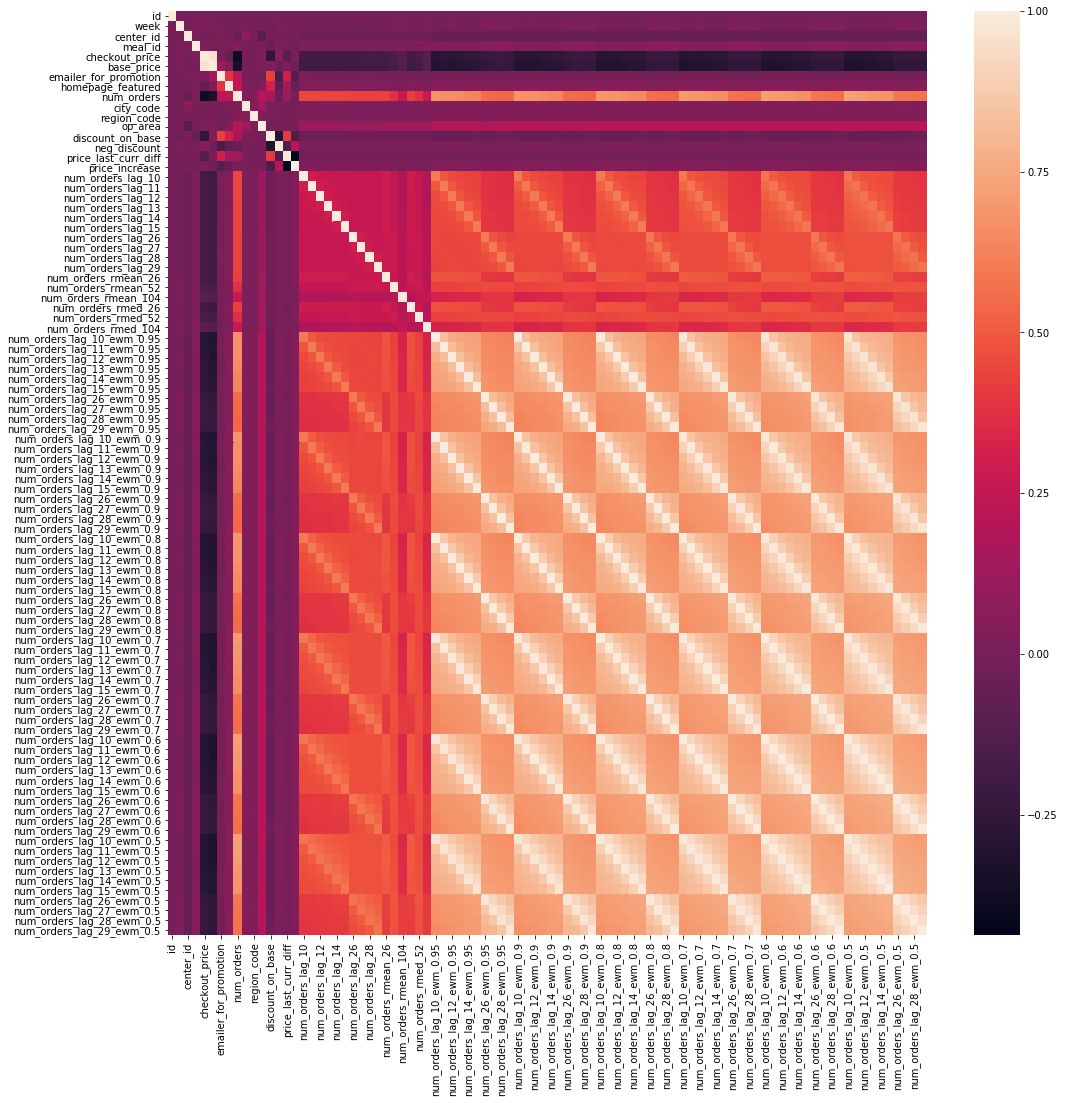

In [34]:
fig, ax = plt.subplots(figsize=(17,17))
sns.heatmap(trn_df.corr(), ax=ax)
plt.show()

### Catboost

In [35]:
avoid_columns1 = ['id', 'num_orders', 'train_or_test']

In [36]:
features1 = [col for col in X_trn.columns if col not in avoid_columns1]

In [37]:
cat_ind1 = [1, 2, 5, 6, 7, 8, 9, 11, 12, 14, 16]

In [38]:
val_pool = cb.Pool(X_val[features1].values, Y_val, cat_features=cat_ind1)

In [39]:
cat_rg1 = cb.CatBoostRegressor(iterations=3000, learning_rate=0.06, depth=8, loss_function='RMSE', random_seed=2018, l2_leaf_reg=10, od_type='Iter', od_wait=400, use_best_model=True)

In [ ]:
cat_rg1.fit(X=X_trn[features1], y=Y_train, eval_set=val_pool, cat_features=cat_ind1, use_best_model=True, verbose=True, plot=False)

bestTest = 0.5030816413 rmse


bestIteration = 621

In [ ]:
cat_rg1.predict(X_val[features1])

In [41]:
100 * np.sqrt(mean_squared_log_error(np.clip(cat_rg1.predict(X_val[features1]), 1, 20), Y_val))

9.721384043259974

In [42]:
print("params : ", cat_rg1.get_params())
print("Learning rate: ", cat_rg1.learning_rate_)
print("tree counts: ", cat_rg1.tree_count_)

params :  {'use_best_model': True, 'od_type': 'Iter', 'loss_function': 'RMSE', 'learning_rate': 0.06, 'depth': 8, 'random_seed': 2018, 'l2_leaf_reg': 10, 'iterations': 3000, 'od_wait': 400}
Learning rate:  0.05999999866
tree counts:  622


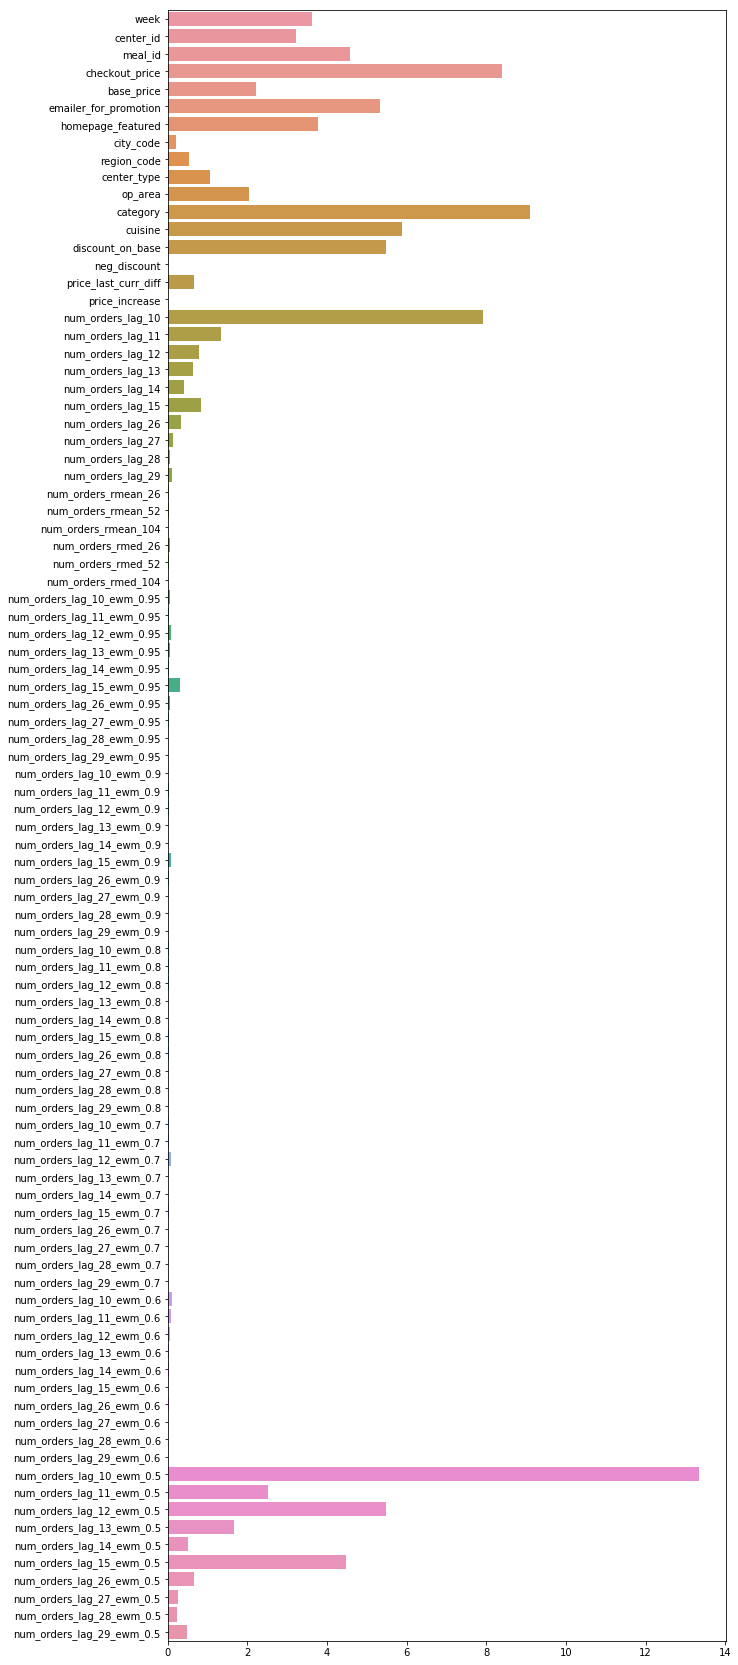

In [43]:
fig, ax = plt.subplots(figsize=(10, 30))
sns.barplot(cat_rg1.feature_importances_, features1, ax=ax)
plt.show()

In [45]:
cat_rg1.predict(X_val[features1])

array([6.74701169, 6.7249461 , 6.74941666, ..., 3.31334952, 3.94374091,
       3.02208158])

In [ ]:
# for catboost plots
# jupyter nbextension enable --py widgetsnbextension
# https://www.slideshare.net/OwenZhang2/tips-for-data-science-competitions